## Student Name: Tadhg Philibin e Silva
## Student ID: 22275363

In [226]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA,KernelPCA
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [227]:
df = pd.read_csv("./insurance.csv")

In [228]:
len(df)

1338

In [229]:
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [230]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

In [231]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

In [232]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [233]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [234]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [235]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

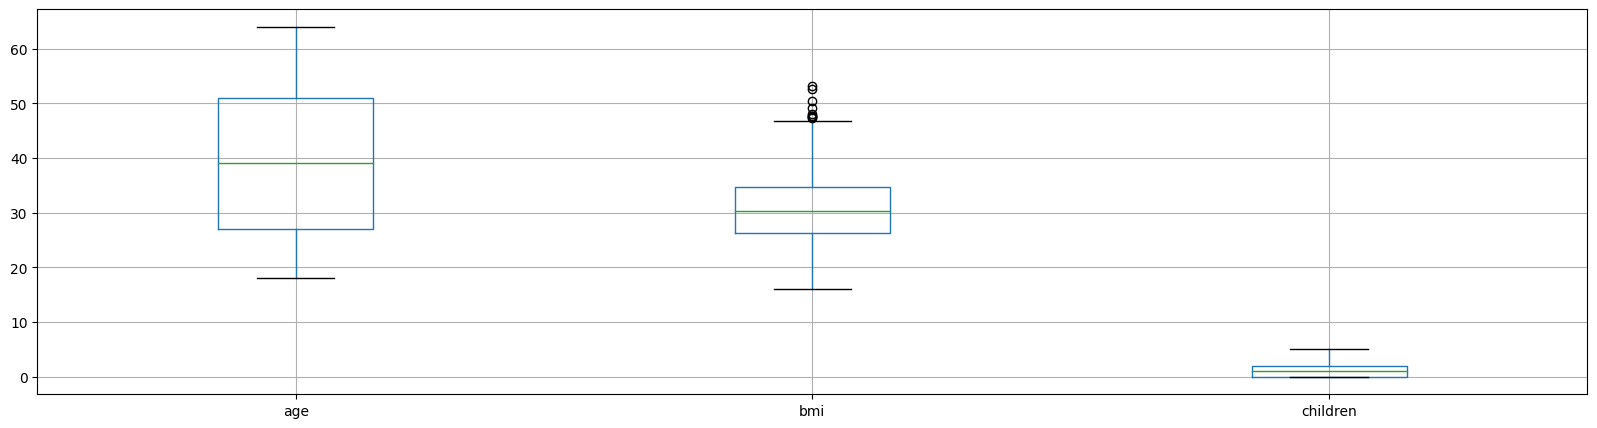

In [236]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

In [237]:
df.boxplot(column=['insurance_cost'])
plt.show()

## Data Preparation

In [238]:
df = pd.get_dummies(df, columns=['gender','region','smoker'],  
                        drop_first=True)

In [239]:
df

age     bmi  children  insurance_cost  gender_male  region_northwest  \
0      18  33.770         1      1725.55230            1                 0   
1      18  34.100         0      1137.01100            1                 0   
2      18  26.315         0      2198.18985            0                 0   
3      18  38.665         2      3393.35635            0                 0   
4      18  35.625         0      2211.13075            0                 0   
...   ...     ...       ...             ...          ...               ...   
1333   64  31.825         2     16069.08475            0                 0   
1334   64  26.885         0     29330.98315            0                 1   
1335   64  26.410         0     14394.55790            1                 0   
1336   64  36.960         2     49577.66240            1                 0   
1337   64  23.760         0     26926.51440            1                 0   

      region_southeast  region_southwest  smoker_yes  
0                    1                 0           0  
1                    1                 0           0  
2                    0                 0           0  
3                    0                 0           0  
4                    0                 0           0  
...                ...               ...         ...  
1333                 0                 0           0  
1334                 0                 0           1  
1335                 0                 0           0  
1336                 1                 0           1  
1337                 1                 0           1  

[1338 rows x 9 columns]

In [240]:
preprocess_pipeline = make_pipeline(StandardScaler())

## Split training, test sets

In [241]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [242]:
# Suppress warnings
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning

@ignore_warnings(category=(ConvergenceWarning,FitFailedWarning,UserWarning))
def runGridSearch(X_train, y_train, pipe, param_grid):
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
    search.fit(X_train, y_train)
    print("Best CV score = %0.3f:" % search.best_score_)
    print("Best parameters: ", search.best_params_)

    # store the best params and best model for later use
    return search.best_params_, search.best_estimator_

## Random Forest Regressor

In [243]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [244]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine', 'precomputed']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [KernelPCA(random_state=0)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__kernel': KERNEL_OPTIONS,
    }  
]

RF_best_params, RF_best_model = runGridSearch(X_train, y_train, pipe, param_grid)

Best CV score = 0.843:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__max_depth': 4}


## Linear Regression

In [245]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

In [246]:
N_FEATURES_OPTIONS = [2, 6, 11]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine', 'precomputed']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS
    },
    {
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [KernelPCA(random_state=0)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__kernel': KERNEL_OPTIONS,
    }    
]


LR_best_params, LR_best_model = runGridSearch(X_train, y_train, pipe, param_grid)

Best CV score = 0.747:
Best parameters:  {'reduce_dim': KernelPCA(kernel='poly', n_components=11, random_state=0), 'reduce_dim__kernel': 'poly', 'reduce_dim__n_components': 11}


In [247]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [248]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

In [249]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

In [250]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model = pipe.fit(X, y)

In [251]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

## Analysis

Random Forest is the clear winner. Both Mean Squred Error and Mean Absolute Error are significantly lower than the LinearRegression model. The R-squared is also higher and tells us that somewhere in the region of 90% of the variance is explained by our model.

In [252]:
from sklearn.linear_model import SGDRegressor

In [253]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('sgd', SGDRegressor())])

In [254]:
PENALTY_OPTIONS = ['l2', 'l1', 'elasticnet']
LOSS_OPTIONS = ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']

N_FEATURES_OPTIONS = [2, 6, 11]
KERNEL_OPTIONS = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine', 'precomputed']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'sgd__loss': LOSS_OPTIONS,
        'sgd__penalty': PENALTY_OPTIONS,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'sgd__loss': LOSS_OPTIONS,
        'sgd__penalty': PENALTY_OPTIONS,
    },
    {
        "reduce_dim": [SelectKBest(mutual_info_classif)],
        "reduce_dim__k": N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [KernelPCA(random_state=0)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__kernel': KERNEL_OPTIONS,
    }    
]

SGD_best_params, SGD_best_model = runGridSearch(X_train, y_train, pipe, param_grid)




/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linea

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linea

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linea

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linea

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linea

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1551: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linea

Best CV score = 0.747:
Best parameters:  {'reduce_dim': KernelPCA(kernel='poly', n_components=11, random_state=0), 'reduce_dim__kernel': 'poly', 'reduce_dim__n_components': 11}


In [255]:
SGD_mse, SGD_mae, SGD_r2 = evaluate_model(X_test, y_test, SGD_best_model)

In [256]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Stochastic Gradient Descent': SGD_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'Stochastic Gradient Descent': SGD_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'Stochastic Gradient Descent': SGD_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])
plt.show()

## Comparing SGD to Random Forest, Linear Regression

Unfortunately, Stochastic Gradient Descent presented no real benefit over the normal LinearRegression model. Random forest remains the superior model in this context.

# Alternative dimension reduction techniques

The KernelPCA approach to dimensionality reduction seems to have performed well for both the LinearRegression and StochasticGradientDescent models. Unfortunately, neither of these models were particularly effective, compared to RandomForest. 

SelectKBest was not chosen by any of the GridSearches so we can assume it was not particular effective in this instance. Perhaps with finer tuning it could perform better.